In [2]:
import matplotlib.pyplot as plt
import nest as sim
import numpy as np
sim.ResetKernel()

# sim_len = 6000

Nlandmarks = 5
N_view = 50

# srt_tm = 2000.
# stp_tm = 8000.

In [2]:
def plotSpks(ax,t,s): # define function to plot spikes in a common way
    ax.plot(t,s,'.')
    ax.set_ylabel('Neuron')
    ax.set_xlabel('Time (ms)')
    ax.set_xlim([0,sim_len])

In [3]:
sim.SetDefaults("stdp_synapse",{"tau_plus": 15.0})
syn_dict = {"model": "stdp_synapse", "alpha": 0.5,"weight": 0.,'Wmax':200.,'delay': 1.,'lambda':.1}

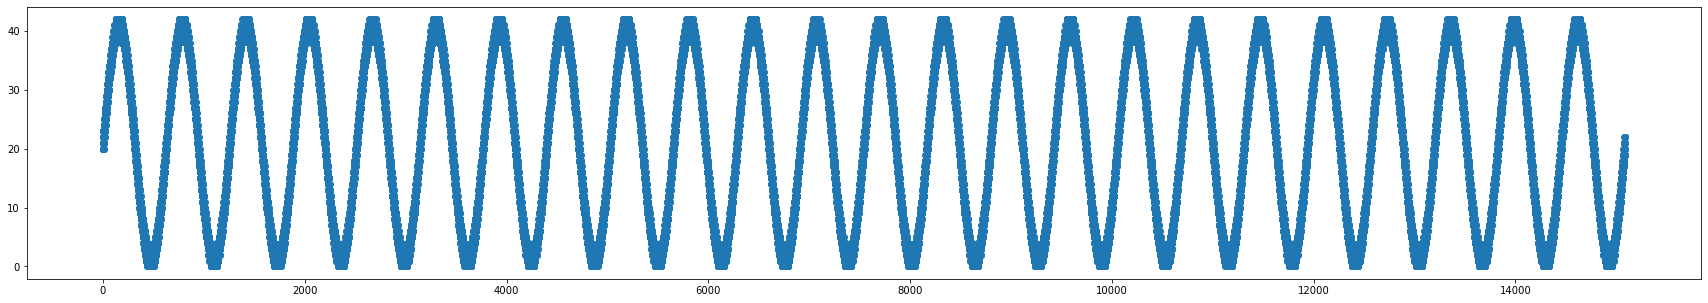

In [4]:
#make sinusoid of HD activity
diam = 4
sin = ((np.sin(np.arange(np.pi*800)/100)+1)*20)//1
orig_sin = sin
for i in range(5):
    sin = np.append(sin,orig_sin)
time = np.arange(1,len(sin)+1)*1.
orig_sin = sin
orig_time = time

m = np.ceil(np.max(orig_time)/500)*500
temp = []
temptime=[]
for i in range(diam):
    temp = np.append(temp,sin+i)
    temptime = np.append(temptime,time)
sin = np.append(sin,temp)
time = np.append(time,temptime)

plt.figure(figsize=(30, 5))
plt.scatter(time,sin)

N = int(np.max(sin))

sim_len = m*2

In [5]:
HD = sim.Create("iaf_psc_alpha",N)
g1 = sim.Create("iaf_psc_alpha",N)
view = sim.Create("iaf_psc_alpha",N_view, params={"tau_minus": 15.0})


In [6]:
params=[]
for i in range(N):
    idx = np.where(sin == i)
    spktms = time[idx]
    params.append({'spike_times':np.sort(spktms)})
    
HD_spikes = sim.Create('spike_generator', N, params)
sim.Connect(HD_spikes,HD,'one_to_one',syn_spec={'weight': 500, 'delay': 0.1})

3
[array([47, 48, 49,  0,  1,  2,  3]), array([ 7,  8,  9, 10, 11, 12, 13]), array([17, 18, 19, 20, 21, 22, 23]), array([27, 28, 29, 30, 31, 32, 33]), array([37, 38, 39, 40, 41, 42, 43])]


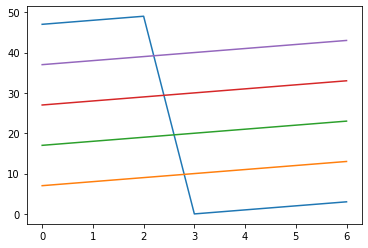

In [7]:
# import random
# patterns = []
# for i in range(Nlandmarks):
#     patterns.append(random.sample(range(0, N_view),10))
# plt.plot(np.array(patterns).T)
# patterns

rad = N_view//Nlandmarks
rad = min(3,rad)
print(rad)
patterns = []
for i in range(Nlandmarks):
    pat = []
    for j in range(-rad,rad+1):
        p = (i*(N_view//Nlandmarks) + j)
        if p >= N_view:
            p = p- N_view
        elif p < 0:
            p = p+N_view
        pat.append(p)
    plt.plot(pat)
    patterns.append(np.array(pat))
print(patterns)

In [8]:
# find 10 evenly distributed head directions
params2 = []
viewspikes = [[] for i in range(N_view)]
I_value = 300.
landmarkHDs = np.around(np.arange(0,2*np.pi,(2*np.pi)/Nlandmarks) * N/(2*np.pi))
for idx,landmark in enumerate(landmarkHDs):
    landmarktimes = np.sort(np.unique(orig_time[orig_sin == landmark]))
    landmarktimes = np.append(landmarktimes,landmarktimes+m)
#     print(landmarktimes)
#     print(patterns[idx])
    for cell in patterns[idx]:
        viewspikes[cell].extend(landmarktimes)

for v in range(N_view):        
    params2.append({'spike_times':np.sort(np.unique(viewspikes[v]))})

view_spikes = sim.Create('spike_generator', N_view, params2)
sim.Connect(view_spikes,view,'one_to_one',syn_spec={'weight': 300, 'delay': 0.1})

In [9]:
# sim.Connect(HD,g1, "one_to_one", syn_spec={'weight': 500, 'delay': 0.1})
sim.Connect(view,HD, "all_to_all", syn_dict)

In [10]:
HD_spikes = sim.Create("spike_detector", 1, params={"withgid": True,"withtime": True})
view_spikes = sim.Create("spike_detector", 1, params={"withgid": True,"withtime": True})

sim.Connect(HD,HD_spikes)
sim.Connect(view,view_spikes)


In [11]:
sim.Simulate(sim_len)

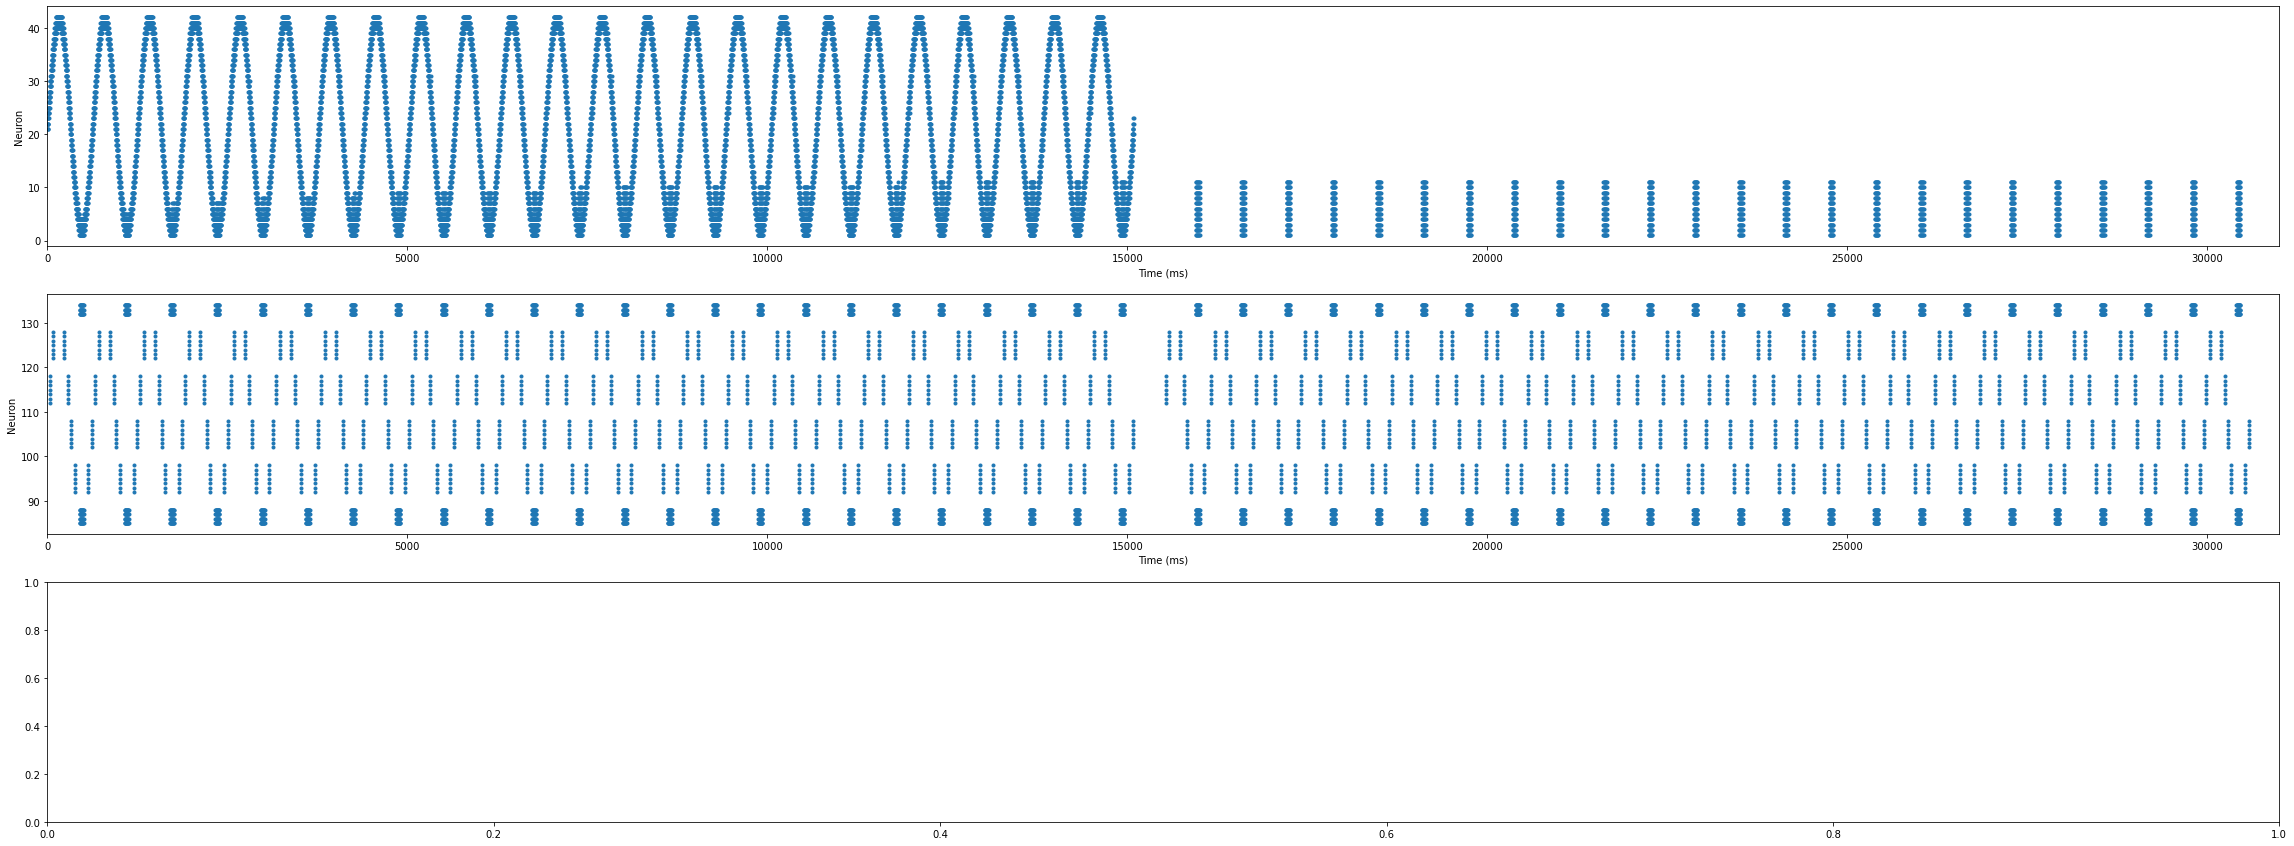

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1,figsize=(40, 15),facecolor='w')

ev = sim.GetStatus(HD_spikes)[0]['events']
t = ev['times']
sp = ev['senders']
plotSpks(ax1,t,sp)

ev = sim.GetStatus(view_spikes)[0]['events']
t = ev['times']
sp = ev['senders']
plotSpks(ax2,t,sp)